In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from icecream import ic
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import umap
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
import seaborn as sns

In [13]:
def plot_umap_paper(n_neighbors, min_dist, metric, n_components, epsilon, min_samples, testing:bool=False):
    dataset_raw = pd.read_csv("./UMAP_old/dataset_complete.csv")
    subset_df = pd.read_csv("./UMAP_old/dataset_reference.csv")

    targets = [
        "total_energy",
        "ionization_potential",
        "electron_affinity",
        "band_gap",
        "electronegativity",
        "Fermi_energy",
        "energy_per_atom",
        "distribution_mean",
    ]

    # dataset = dataset_raw.dropna(axis=1)
    indexes = subset_df.index
    dataset = dataset_raw.dropna(axis=1)
    # dataset = dataset_raw.loc[indexes].dropna(axis=1)

    el_aff = dataset.index[dataset["electron_affinity"] == 0.0].tolist()
    elneg = dataset.index[dataset["electronegativity"] == 0.0].tolist()
    i_pot = dataset.index[dataset["ionization_potential"] == 0.0].tolist()
    Fermi = dataset.index[dataset["Fermi_energy"] == 0.0].tolist()
    tot_e = dataset.index[dataset["total_energy"] == 0.0].tolist()
    band_g = dataset.index[dataset["band_gap"] == 0.0].tolist()

    indices = [*el_aff, *elneg, *i_pot, *Fermi, *tot_e, *band_g]

    dataset = dataset.drop(indices, axis=0)

    data = dataset.drop(
        ["file_name", "Unnamed: 0"] + targets, axis=1
    )  # .dropna(axis=1)
    # print(data.columns)

    le = LabelEncoder()
    data["Shape"] = le.fit_transform(data["Shape"])

    reducer = umap.UMAP(
        n_neighbors=n_neighbors, min_dist=min_dist, random_state=42, metric=metric, n_components=n_components
    )
    embedding = reducer.fit_transform(data)
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
    )
    plt.title("UMAP projection of graphene oxyde flakes")
    plt.savefig("./UMAP_DBSCAN/umap.png") if not testing else None
    plt.show()
    
    # Perform DBSCAN clustering
    epsilon = epsilon  # Adjust the epsilon parameter for DBSCAN
    min_samples = min_samples  # Adjust the minimum number of samples for DBSCAN
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    cluster_assignments = dbscan.fit_predict(embedding)
    
    unique_clusters = set(cluster_assignments) - {-1}

    # Number of clusters
    num_clusters = len(unique_clusters)
    print(f"Number of clusters: {num_clusters}")
    
    dataset["cluster_id"] = cluster_assignments
    dataset["embedding_0"] = embedding[:, 0]
    dataset["embedding_1"] = embedding[:, 1]
    dataset.to_csv("./UMAP_DBSCAN/umap_results.csv") if not testing else None
    
    colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
        "#FF4E00",
        "#00F0A2",
        "#FFEF00",
        "#8400FF",
        "#00FF60",
        "#FF00FB",
        "#8A4117",
        "#FFD42D",
        "#7C7676",
        "#0C9BBF",
        "#ff6f3c",
        "#2E8B57",
        "#4B0082",
        "#FF00FF",
        "#00FFFF",
    ]

    # Plot the DBSCAN clusters (assuming -1 represents noise points)
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=cluster_assignments,
        cmap=ListedColormap(colors, name="custom_colormap"),  # You can choose another colormap
    )
    plt.title("DBSCAN Clustering")
    plt.savefig("./UMAP_DBSCAN/dbscan.png") if not testing else None
    plt.show()

/home/cnrismn/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


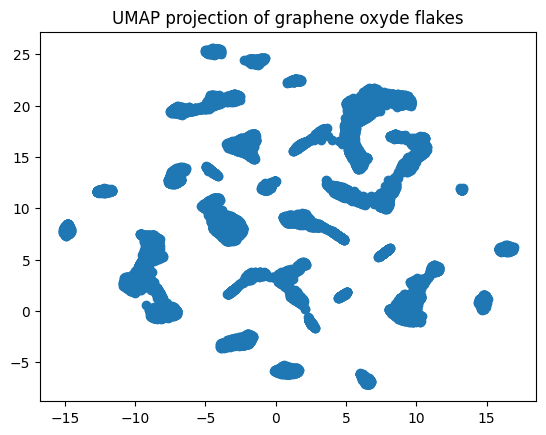

Number of clusters: 25


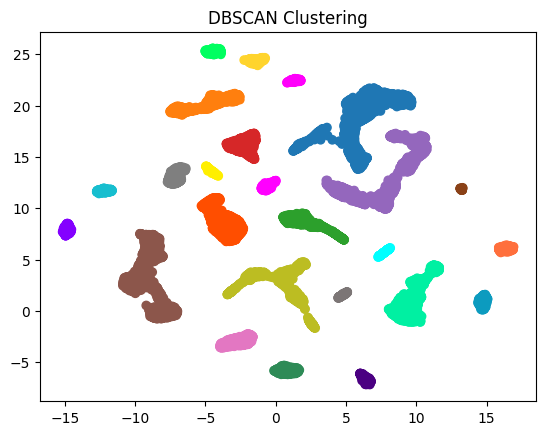

In [14]:
plot_umap_paper(n_neighbors=30, min_dist=0.2, metric="euclidean", n_components=2, epsilon=1.0,min_samples=5, testing=False)

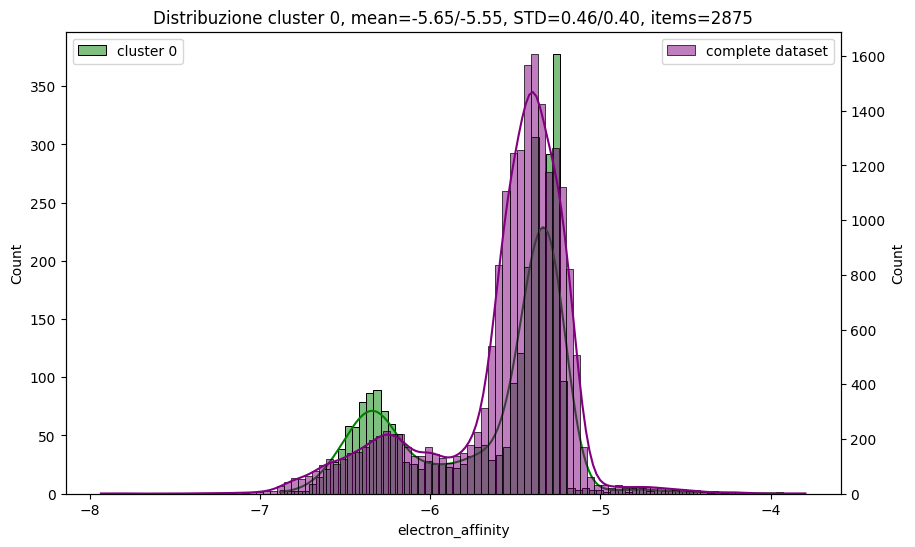

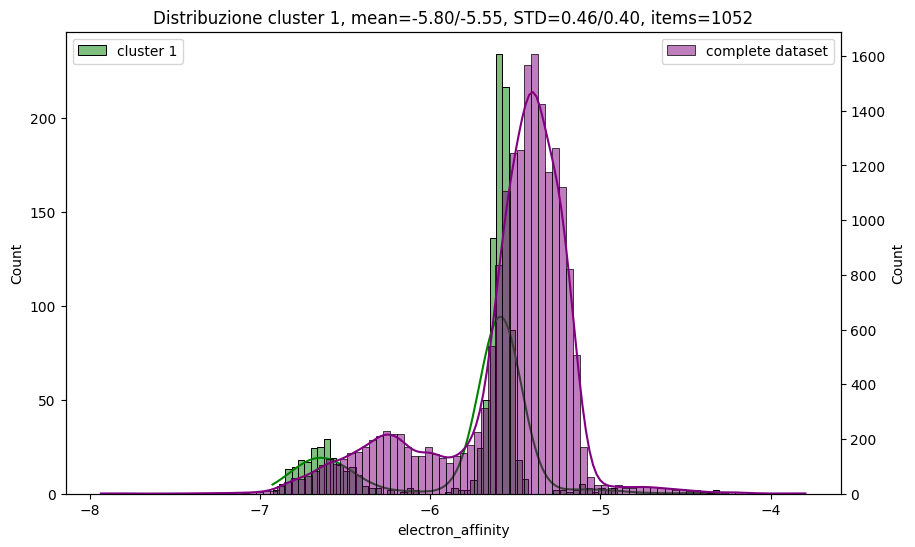

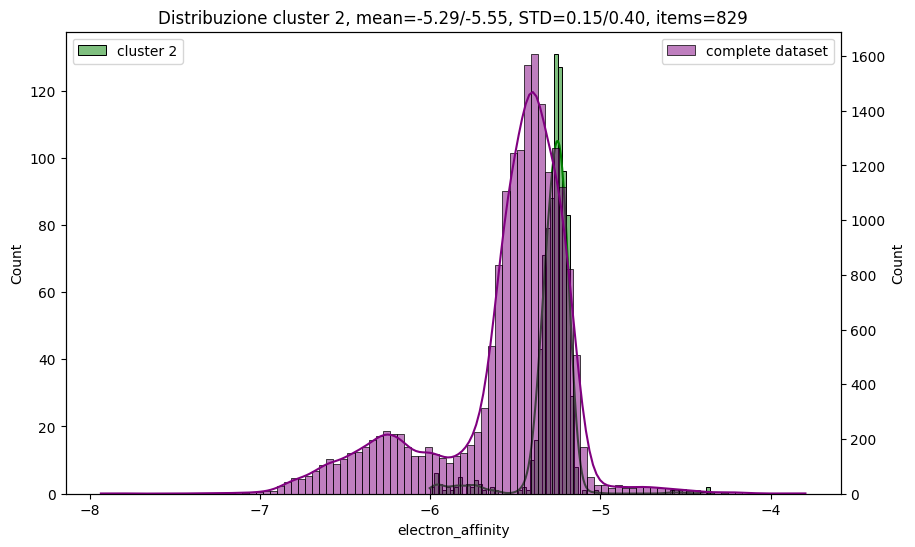

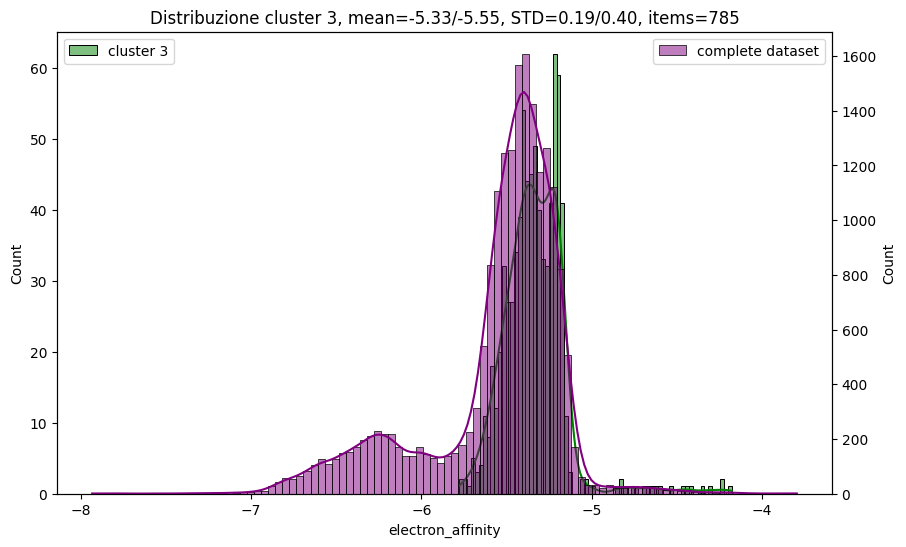

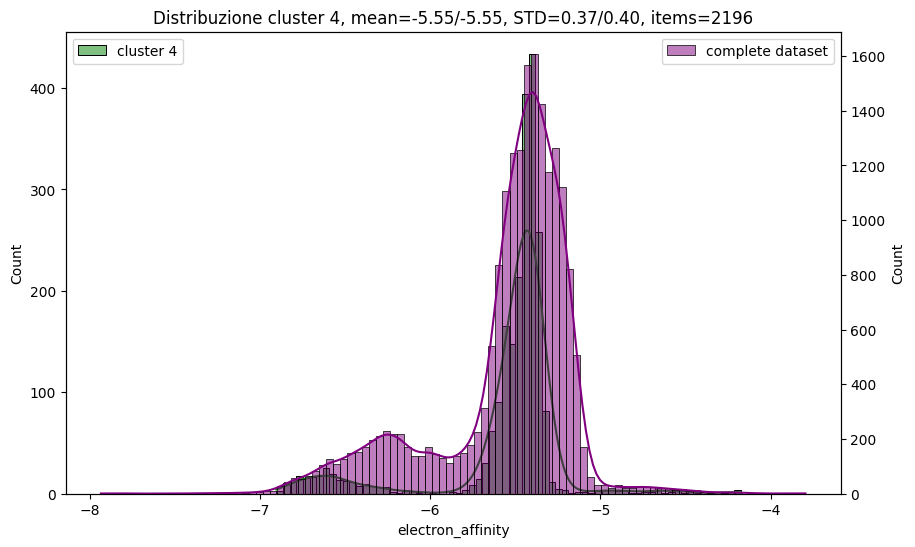

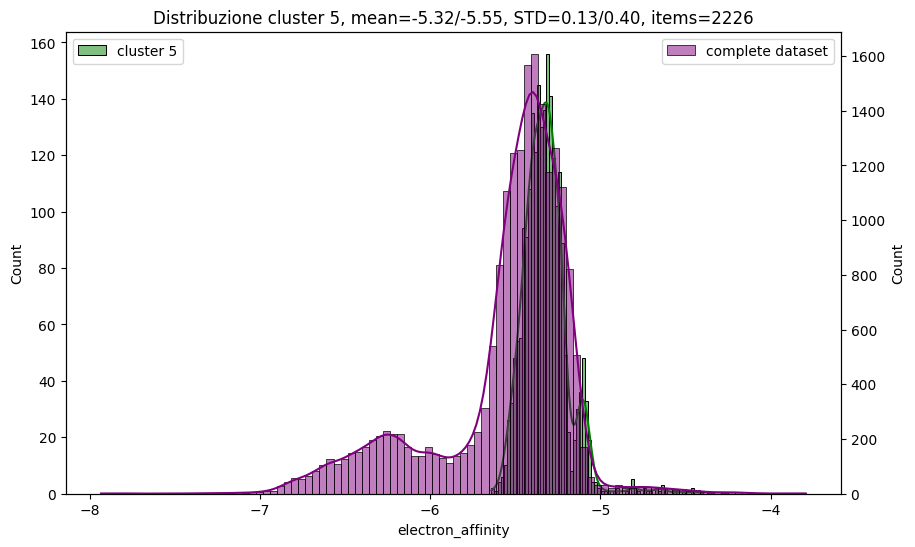

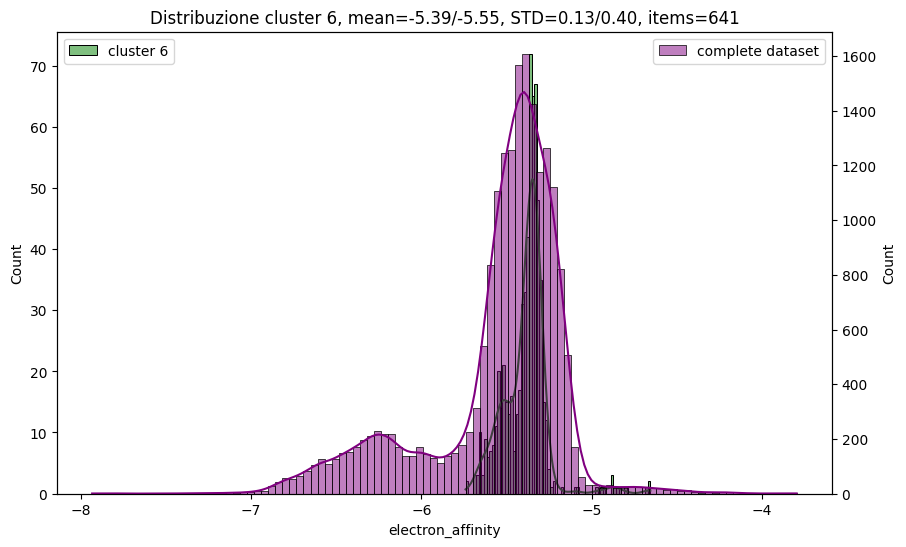

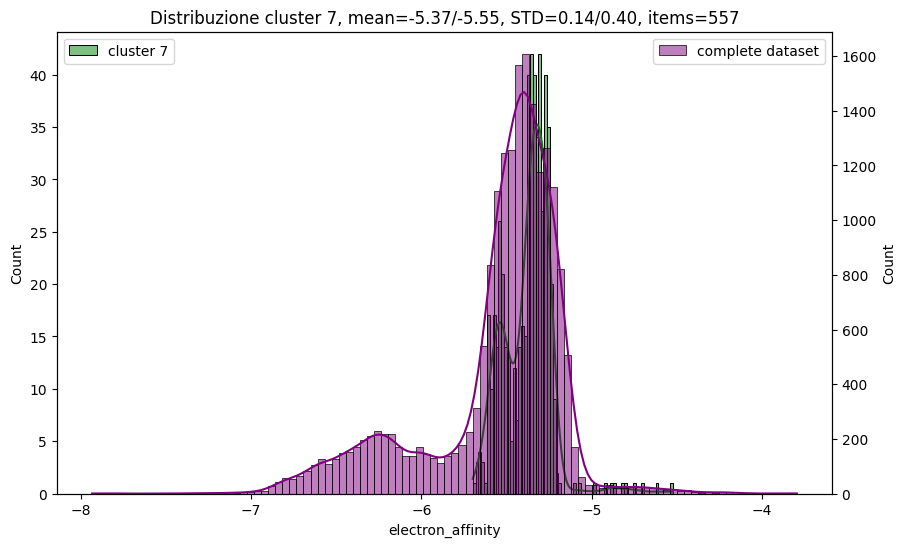

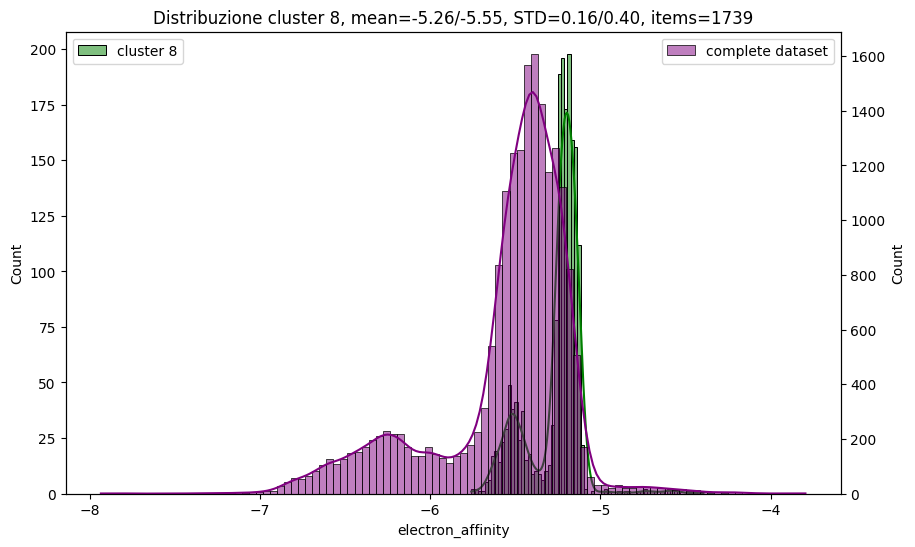

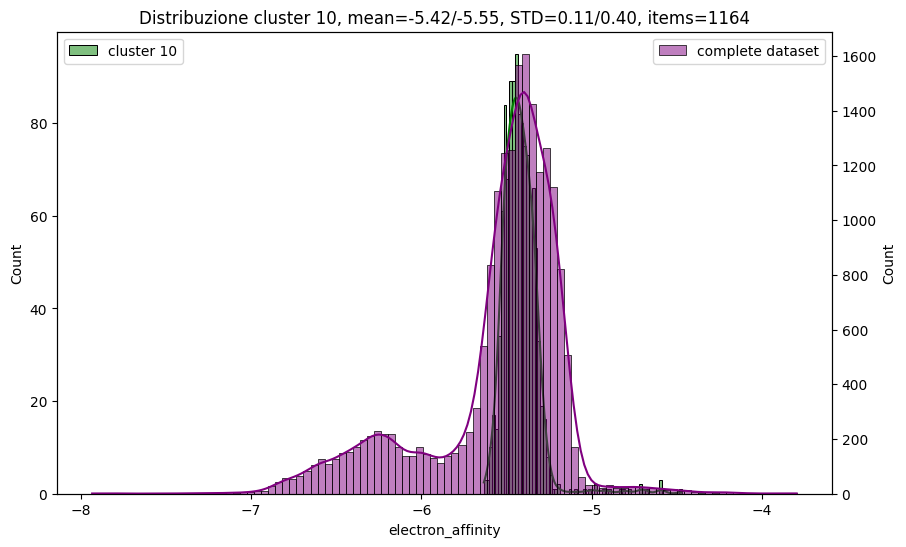

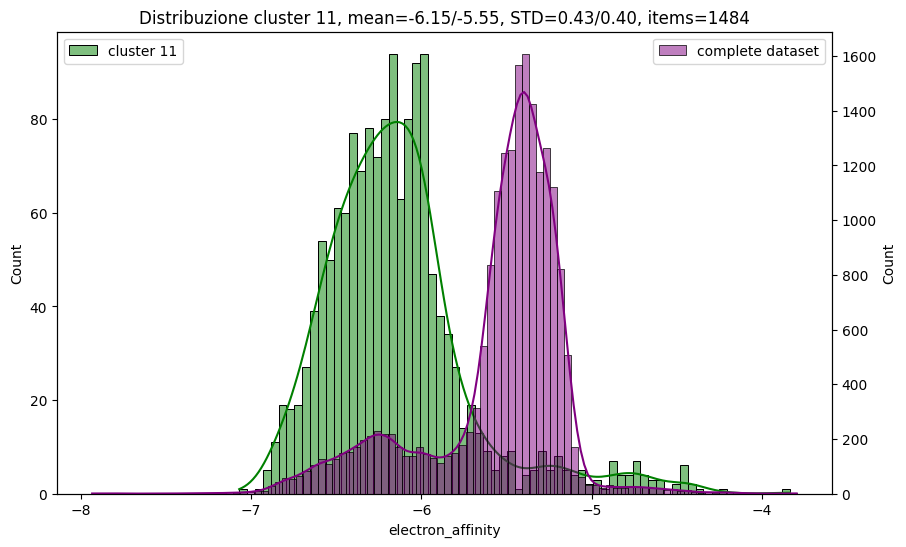

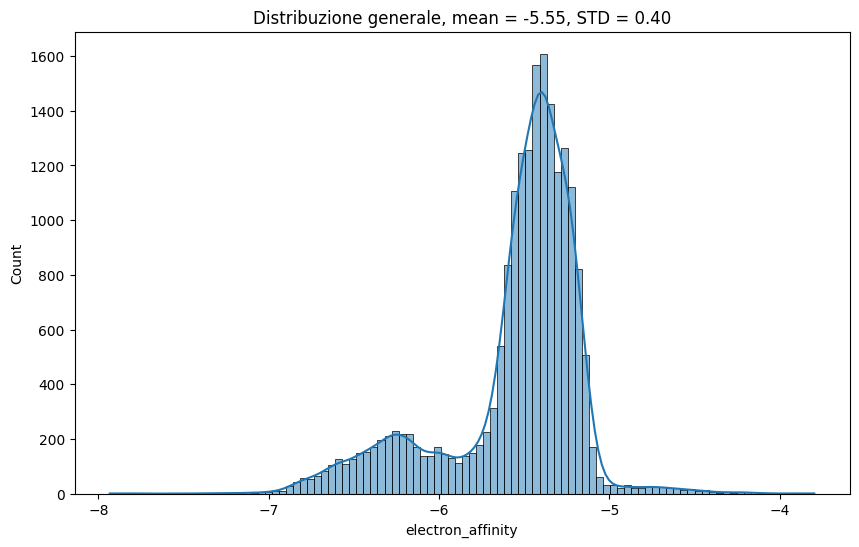

In [15]:
target = "electron_affinity"
df = pd.read_csv("./UMAP_DBSCAN/umap_results.csv")

media_tot = np.mean(df[target])
std_tot = np.std(df[target])

for i in range(0,25):
    df_filtrato = df[df['cluster_id'] == i]
    num_items = len(df_filtrato)
    
    if num_items<500:
        continue
    
    media = np.mean(df_filtrato[target])
    std = np.std(df_filtrato[target])
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    sns.histplot(data=df_filtrato, x=target, ax=ax1, bins=70, kde=True, label=f'cluster {i}', color='green', stat='count')
    ax2 = ax1.twinx()
    sns.histplot(data=df, x=target, ax=ax2, bins=100, kde=True, label='complete dataset', color='purple', stat='count')
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1, labels1, loc='upper left')
    ax2.legend(lines2, labels2, loc='upper right')
    plt.xlabel(target)
    plt.title(f'Distribuzione cluster {i}, mean={media:.2f}/{media_tot:.2f}, STD={std:.2f}/{std_tot:.2f}, items={num_items}')
    plt.show()
    plt.close()

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=target, bins=100, kde=True)  # Puoi regolare i parametri bin e kde secondo le tue esigenze
plt.xlabel(target)
plt.title(f'Distribuzione generale, mean = {media_tot:.2f}, STD = {std_tot:.2f}')
plt.show()

In [16]:
clusters =[0,1,2,3,4,5,6,7,8,10,11]

for cluster in clusters:

    new_df = df.loc[df["cluster_id"] == cluster]

    col_list = ["file_name", "ionization_potential","electronegativity","electron_affinity","Fermi_energy"]

    new_df = new_df.loc[:, col_list].reset_index()

    new_df.to_csv(f"./UMAP_DBSCAN/dataset_cluster_{cluster}.csv")

Plot dei vari fit sui clusters

-6.5389
-2.5565


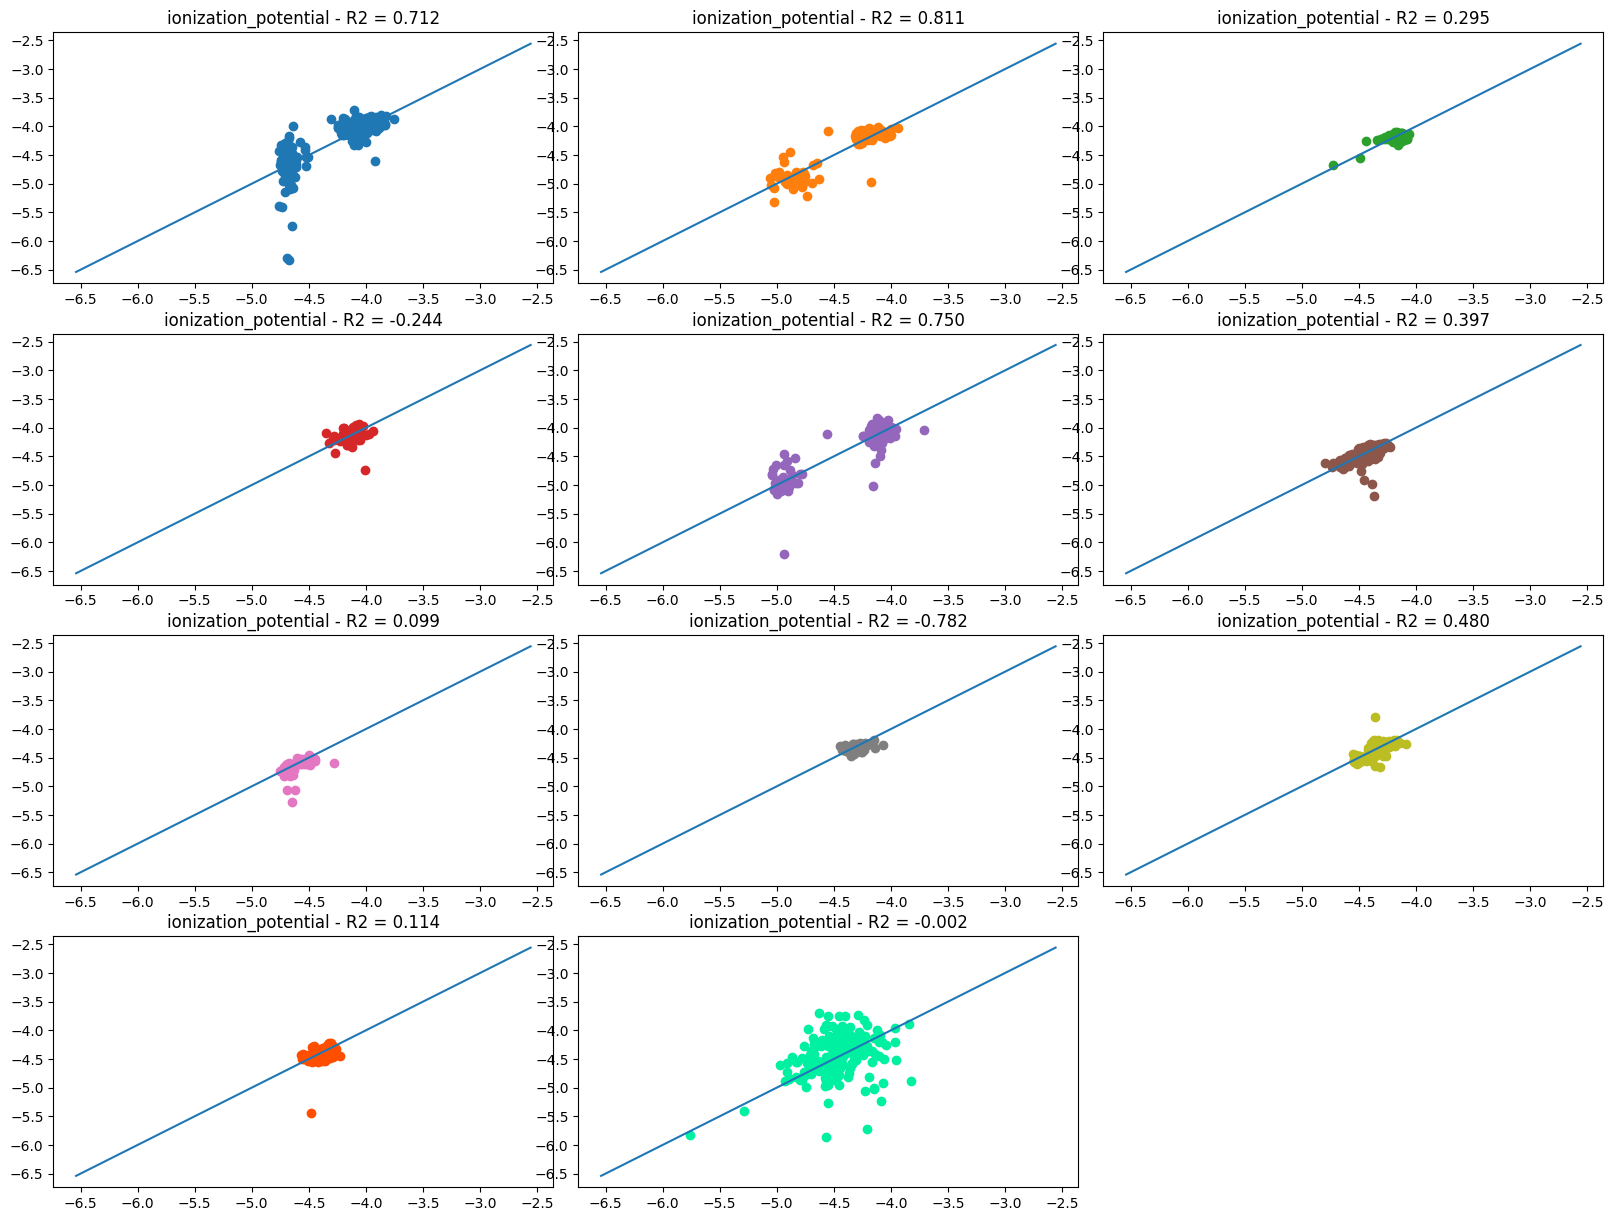

In [41]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import numpy as np

colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#FF4E00",
        "#00F0A2",
    ]


def r2_score(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    mean_y = np.mean(y_true)
    SSR = np.sum((y_pred - y_true) ** 2)
    SST = np.sum((y_true - mean_y) ** 2)
    return 1 - SSR / SST

df = pd.read_csv("/home/cnrismn/git_workspace/GrapheNet/UMAP_DBSCAN/25_clusters/umap_results.csv")
target = "ionization_potential"
clusters =[0,1,2,3,4,5,6,7,8,10,11]

min = np.min(df[target])
max = np.max(df[target])
print(min)
print(max)

paths = []
for cluster in clusters:
    paths.append(f"/home/cnrismn/git_workspace/GrapheNet/UMAP_DBSCAN/25_clusters/cluster_{cluster}/training_dataset/models/{target}/{target}_prediction_results.csv")


# Imposta la griglia 4x3
rows = 4
cols = 3

# Crea una nuova figura con le dimensioni desiderate
fig = plt.figure(figsize=(20, 15))

# Loop attraverso la lista delle immagini e aggiungile alla figura
for i, path in enumerate(paths):
    
    prediction = pd.read_csv(path)
    
    y_hat = prediction[f"{target}_predicted"].to_list()
    y = prediction[f"{target}_real"].to_list()

    fig.add_subplot(rows, cols, i + 1)
    plt.plot(
        [min, max],
        [min, max],
    )
    plt.scatter(y_hat, y, color=colors[i])
    # plt.xlabel("Predictions")
    # plt.ylabel("Targets")
    plt.title(f"{target} - R2 = {r2_score(y_hat,y):.3f}")

# Regola lo spaziamento tra le immagini
plt.subplots_adjust(wspace=0.05, hspace=0.2)

# Mostra la figura con tutte le immagini
plt.show()

Controlo che i colori corrispondano plottando i baricentri dei vari clusters

Cluster = 0, X = 5.84545426987826, Y = 18.49146956173913


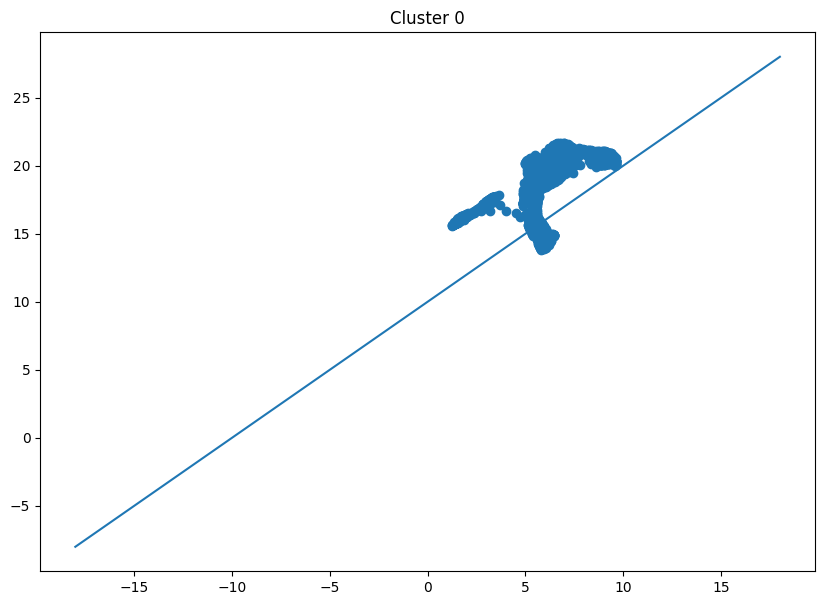

Cluster = 1, X = -5.0891399322243345, Y = 20.110239570342205


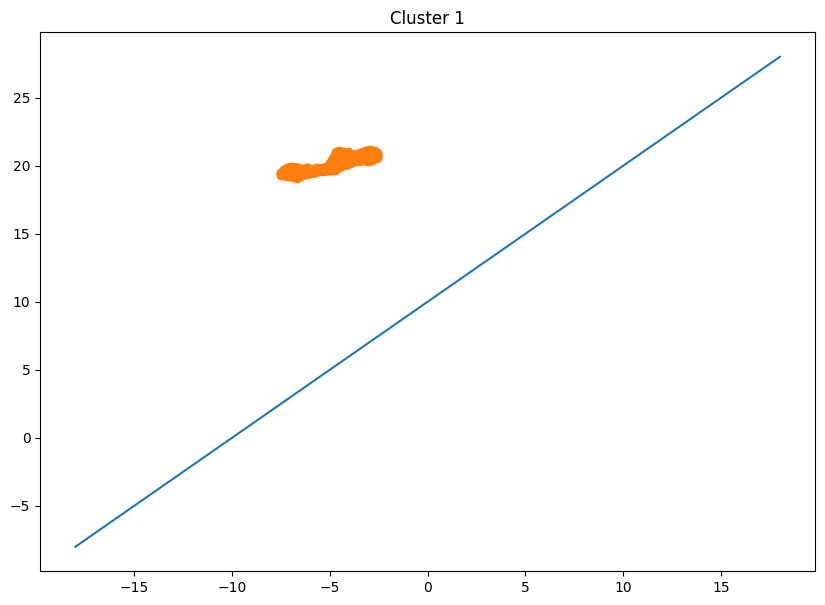

Cluster = 2, X = 2.4716583799879372, Y = 8.402304582629675


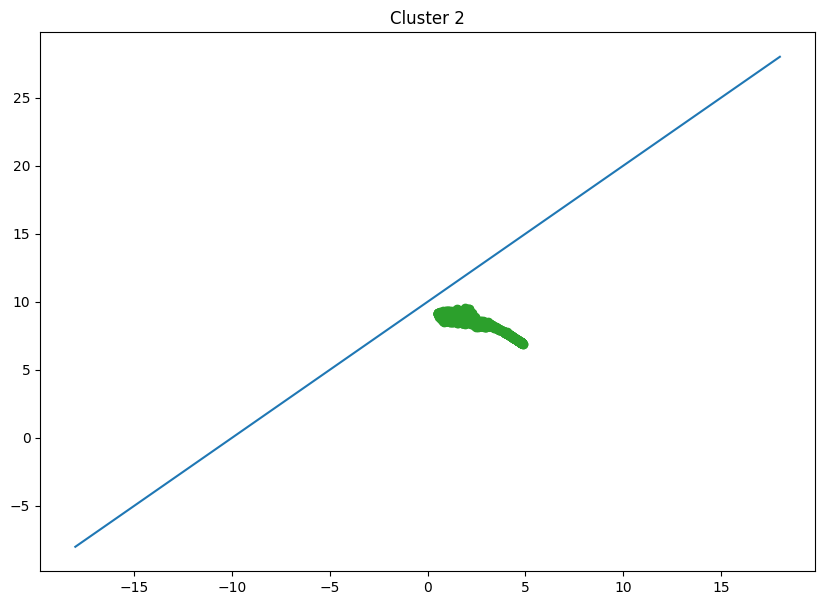

Cluster = 3, X = -2.252697174267516, Y = 16.125366474522295


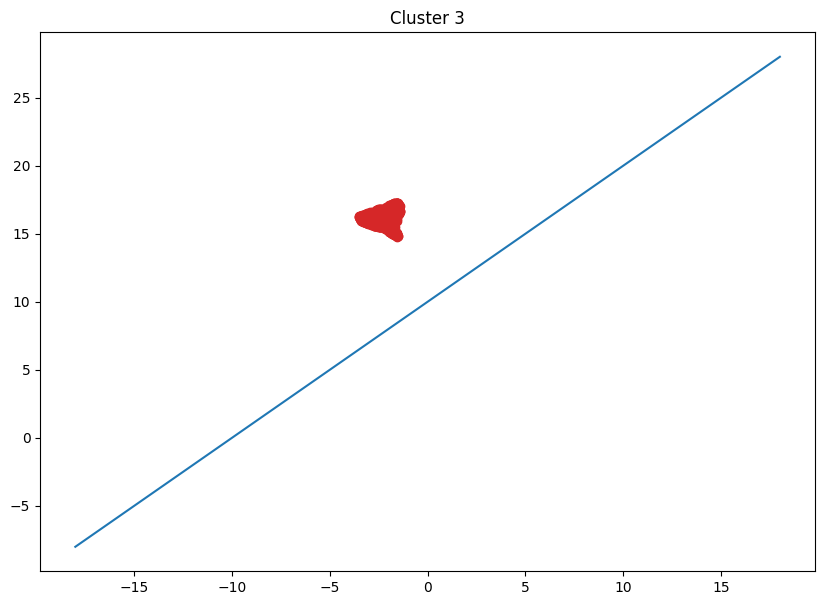

Cluster = 4, X = 7.915459368123861, Y = 13.38087493920765


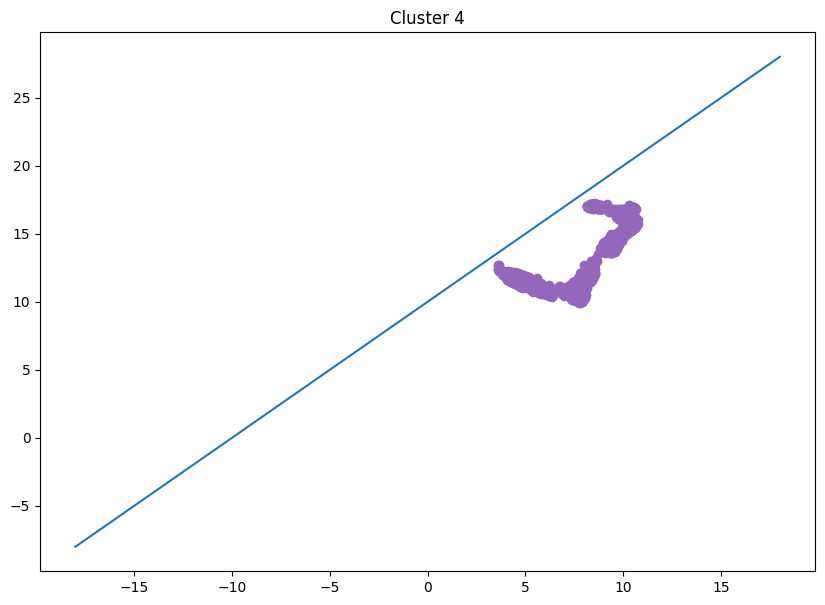

Cluster = 5, X = -8.939855743171607, Y = 3.1980330314083294


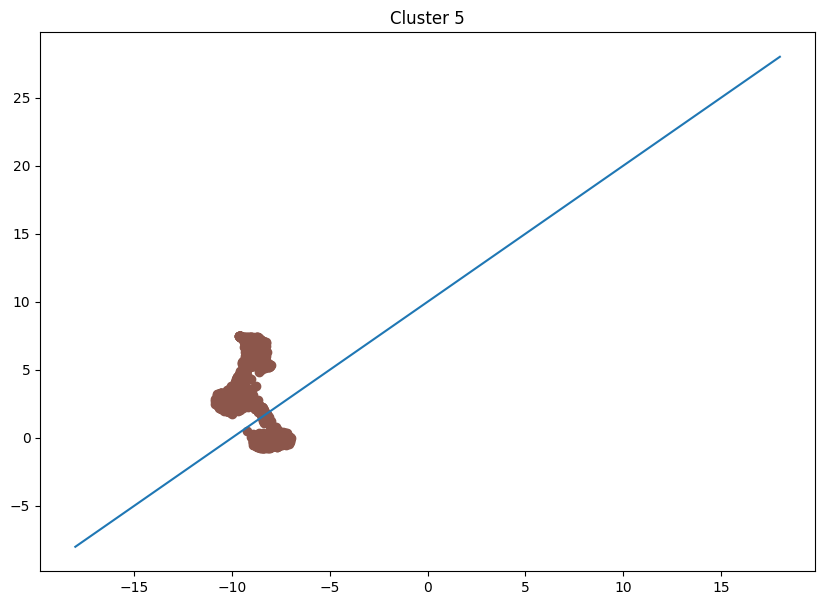

Cluster = 6, X = -2.733272178471139, Y = -3.0047877109204366


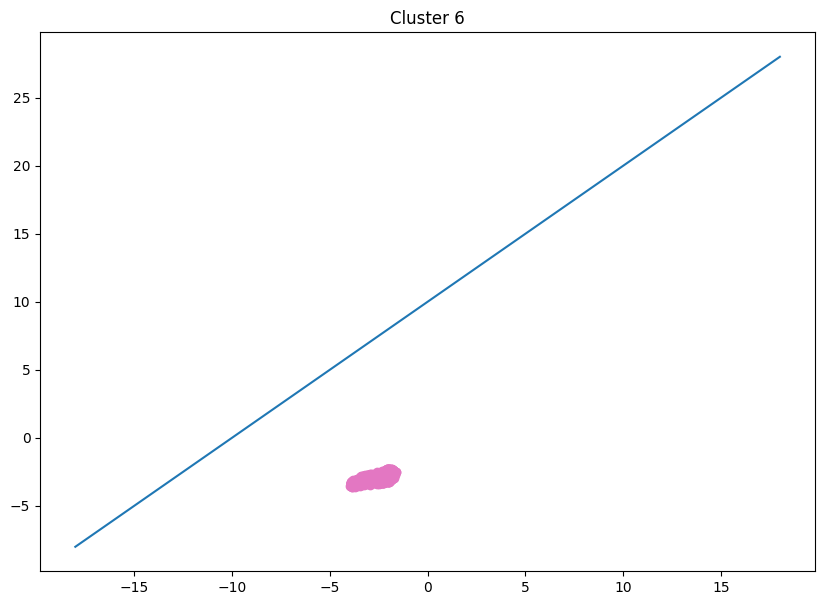

Cluster = 7, X = -7.101390443087971, Y = 13.173535360861761


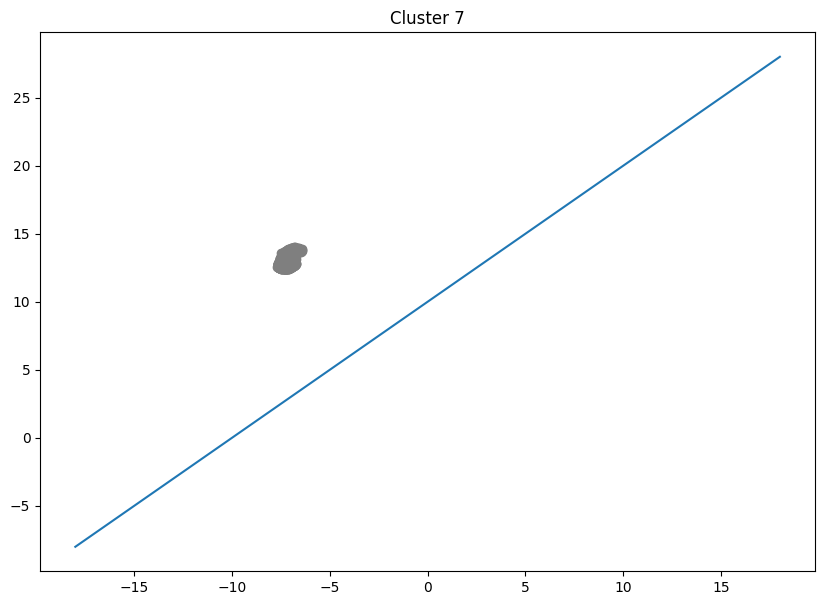

Cluster = 8, X = 0.2612425727889591, Y = 2.3975981740770558


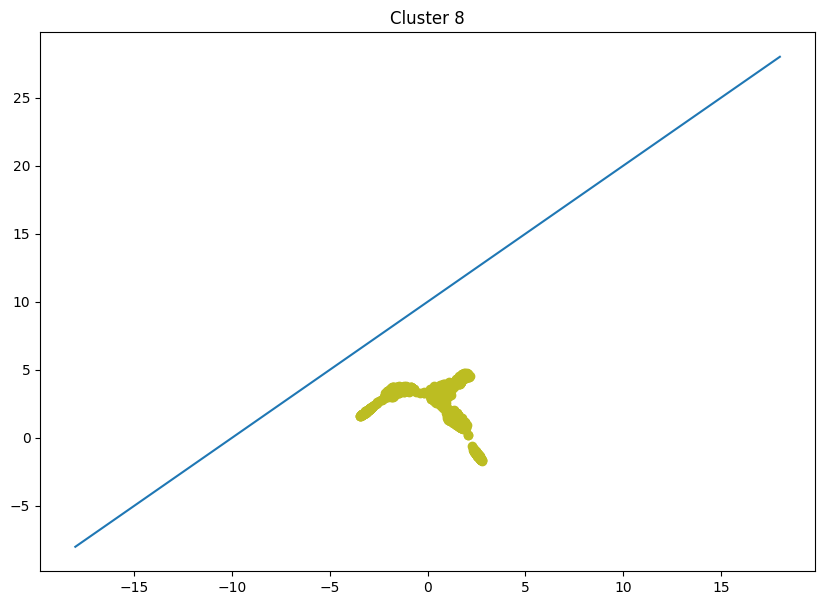

Cluster = 10, X = -3.7532827390893466, Y = 8.766635153951892


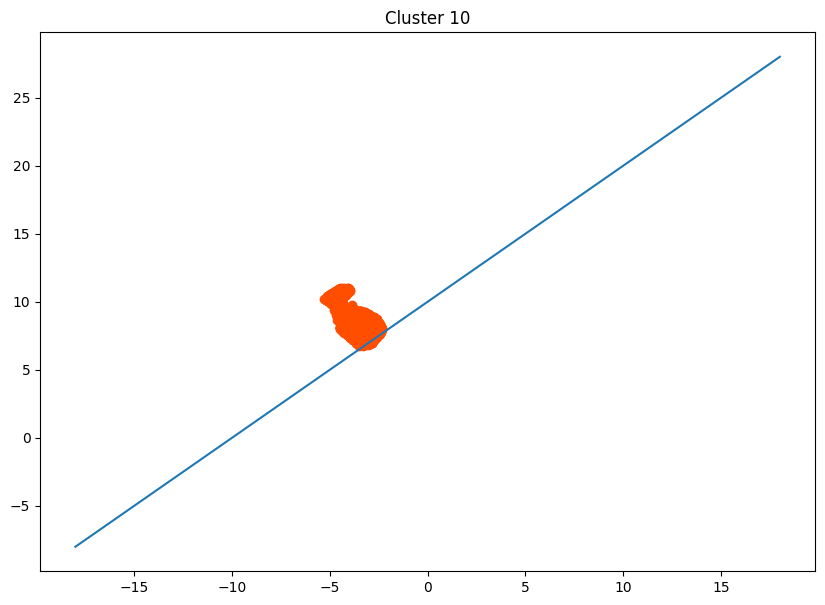

Cluster = 11, X = 9.789386274595687, Y = 1.1710166958837465


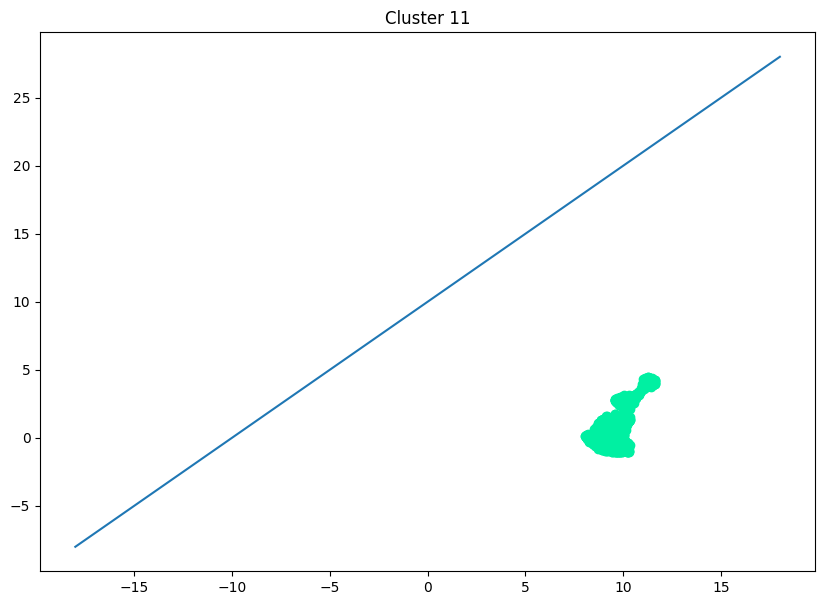

In [42]:
import pandas as pd
import numpy as np

clusters =[0,1,2,3,4,5,6,7,8,10,11]
df = pd.read_csv("/home/cnrismn/git_workspace/GrapheNet/UMAP_DBSCAN/25_clusters/umap_results.csv")

colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
        "#FF4E00",
        "#00F0A2",
        "#FFEF00",
        "#8400FF",
        "#00FF60",
        "#FF00FB",
        "#8A4117",
        "#FFD42D",
        "#7C7676",
        "#0C9BBF",
        "#ff6f3c",
        "#2E8B57",
        "#4B0082",
        "#FF00FF",
        "#00FFFF",
        "#FF4500",
        "#00FF00",
    ]

for cluster in clusters:
    df_filtrato = df[df['cluster_id'] == cluster]
    x_mean = np.mean(df_filtrato["embedding_0"]) 
    y_mean = np.mean(df_filtrato["embedding_1"])
    print(f"Cluster = {cluster}, X = {x_mean}, Y = {y_mean}")
    plt.figure(figsize=(10, 7))
    plt.plot(
        [-18, 18],
        [-8, 28],
    )
    plt.scatter(df_filtrato["embedding_0"], df_filtrato["embedding_1"], color=colors[cluster])
    plt.title(f"Cluster {cluster}")
    plt.show()

Plot dei best e worst fit per EA

-6.5389
-2.5565


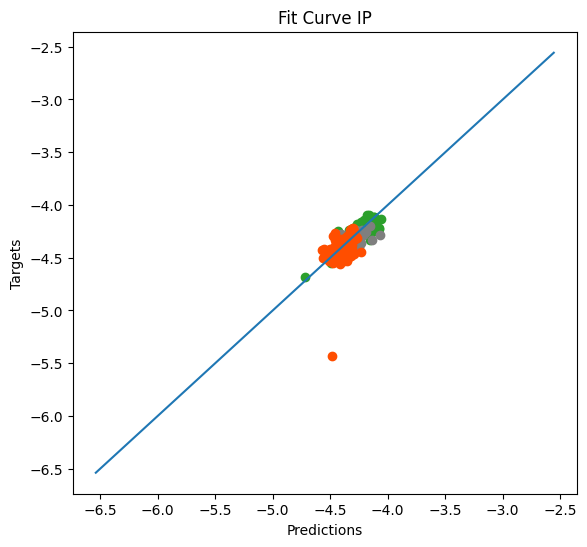

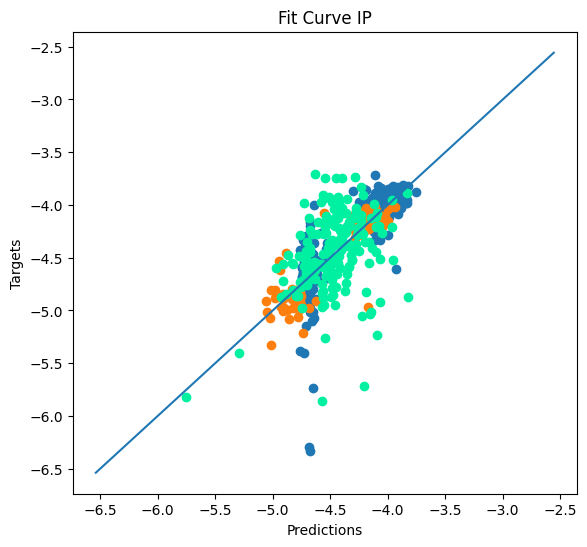

In [43]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import numpy as np

colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
        "#FF4E00",
        "#00F0A2",
        "#FFEF00",
        "#8400FF",
        "#00FF60",
        "#FF00FB",
        "#8A4117",
        "#FFD42D",
        "#7C7676",
        "#0C9BBF",
        "#ff6f3c",
        "#2E8B57",
        "#4B0082",
        "#FF00FF",
        "#00FFFF",
        "#FF4500",
        "#00FF00",
    ]


df = pd.read_csv("/home/cnrismn/git_workspace/GrapheNet/UMAP_DBSCAN/25_clusters/umap_results.csv")
target = "ionization_potential"
best_clusters =[2,7,10]
worst_clusters =[0,1,11]

min = np.min(df[target])
max = np.max(df[target])
print(min)
print(max)

best_paths = []
for cluster in best_clusters:
    best_paths.append(f"/home/cnrismn/git_workspace/GrapheNet/UMAP_DBSCAN/25_clusters/cluster_{cluster}/training_dataset/models/{target}/{target}_prediction_results.csv")
    
worst_paths = []
for cluster in worst_clusters:
    worst_paths.append(f"/home/cnrismn/git_workspace/GrapheNet/UMAP_DBSCAN/25_clusters/cluster_{cluster}/training_dataset/models/{target}/{target}_prediction_results.csv")

# Crea una nuova figura con le dimensioni desiderate
fig = plt.figure(figsize=(6.5, 6))
plt.plot(
        [min, max],
        [min, max],
    )
plt.xlabel("Predictions")
plt.ylabel("Targets")
plt.title("Fit Curve IP")

# Loop attraverso la lista delle immagini e aggiungile alla figura
for path, cluster in (zip(best_paths,best_clusters)):
    
    prediction = pd.read_csv(path)
    
    y_hat = prediction[f"{target}_predicted"].to_list()
    y = prediction[f"{target}_real"].to_list()

    plt.scatter(y_hat, y, color=colors[cluster])

# Mostra la figura con tutte le immagini
plt.show()
plt.close()

fig = plt.figure(figsize=(6.5, 6))
plt.plot(
        [min, max],
        [min, max],
    )
plt.xlabel("Predictions")
plt.ylabel("Targets")
plt.title("Fit Curve IP")

# Loop attraverso la lista delle immagini e aggiungile alla figura
for path, cluster in (zip(worst_paths,worst_clusters)):
    
    prediction = pd.read_csv(path)
    
    y_hat = prediction[f"{target}_predicted"].to_list()
    y = prediction[f"{target}_real"].to_list()

    plt.scatter(y_hat, y, color=colors[cluster])

# Mostra la figura con tutte le immagini
plt.show()
plt.close()

Ora faccio i plot per il paper

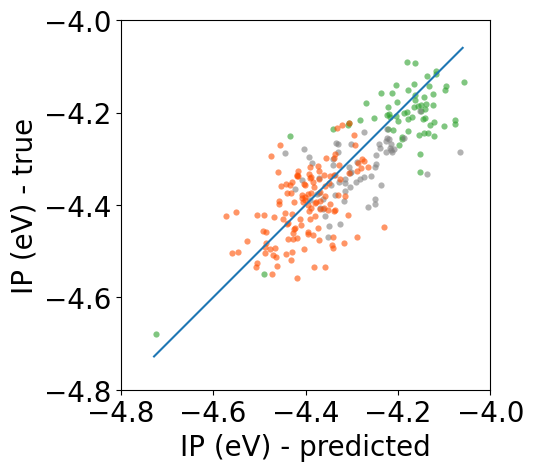

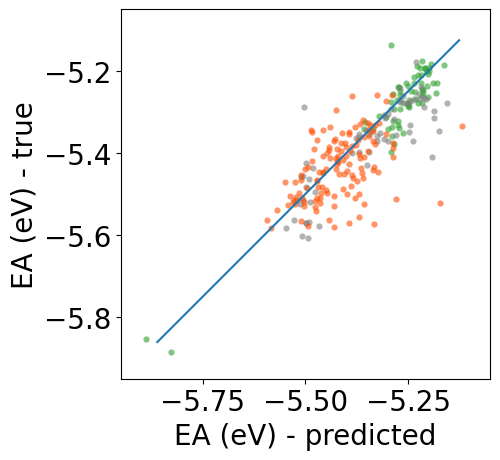

In [90]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import numpy as np

target="ionization_potential"
colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
        "#FF4E00",
        "#00F0A2",
        "#FFEF00",
        "#8400FF",
        "#00FF60",
        "#FF00FB",
        "#8A4117",
        "#FFD42D",
        "#7C7676",
        "#0C9BBF",
        "#ff6f3c",
        "#2E8B57",
        "#4B0082",
        "#FF00FF",
        "#00FFFF",
        "#FF4500",
        "#00FF00",
    ]

best_clusters =[2,7,10]
best_paths = []
for cluster in best_clusters:
    best_paths.append(f"/home/cnrismn/git_workspace/GrapheNet/UMAP_DBSCAN/25_clusters/cluster_{cluster}/training_dataset/models/{target}/{target}_prediction_results.csv")

bound = [-4.8, -4]

# Crea una nuova figura con le dimensioni desiderate
fig, ax1 = plt.subplots()
ax1.set_xlabel('IP (eV) - predicted',size=20)
ax1.set_ylabel('IP (eV) - true',size=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_xlim(bound)
ax1.set_ylim(bound)
ax1.set_box_aspect(1)
lowbound1 = bound[0]*0.985
lowbound2 = bound[1]*1.015
lowbound = [lowbound1, lowbound2]
ax1.plot(lowbound, lowbound)

# Loop attraverso la lista delle immagini e aggiungile alla figura
for path, cluster in (zip(best_paths,best_clusters)):
    
    prediction = pd.read_csv(path)
    
    y_hat = prediction[f"{target}_predicted"].to_list()
    y = prediction[f"{target}_real"].to_list()

    ax1.scatter(y_hat, y, color=colors[cluster],s=20, alpha=0.6,linewidth=0)

# Mostra la figura con tutte le immagini
plt.show()
plt.close()

target="electron_affinity"
best_paths.clear()
for cluster in best_clusters:
    best_paths.append(f"/home/cnrismn/git_workspace/GrapheNet/UMAP_DBSCAN/25_clusters/cluster_{cluster}/training_dataset/models/{target}/{target}_prediction_results.csv")

bound = [-5.95, -5.05]

fig, ax1 = plt.subplots()
ax1.set_xlabel('EA (eV) - predicted',size=20)
ax1.set_ylabel('EA (eV) - true',size=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_xlim(bound)
ax1.set_ylim(bound)
ax1.set_box_aspect(1)
lowbound1 = bound[0]*0.985
lowbound2 = bound[1]*1.015
lowbound = [lowbound1, lowbound2]
ax1.plot(lowbound, lowbound)

# Loop attraverso la lista delle immagini e aggiungile alla figura
for path, cluster in (zip(best_paths,best_clusters)):
    
    prediction = pd.read_csv(path)
    
    y_hat = prediction[f"{target}_predicted"].to_list()
    y = prediction[f"{target}_real"].to_list()

    ax1.scatter(y_hat, y, color=colors[cluster],s=20, alpha=0.6,linewidth=0)

# Mostra la figura con tutte le immagini
plt.show()
plt.close()

Disegno un cerchio su UMAP

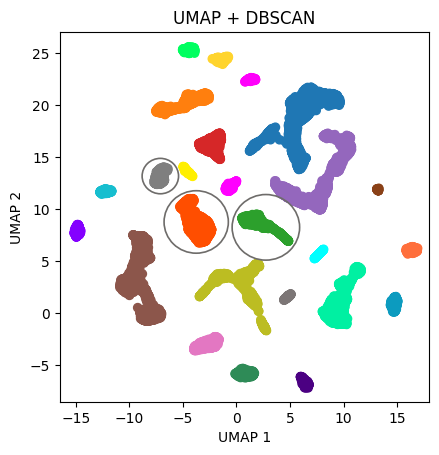

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import pandas as pd

df = pd.read_csv("/home/cnrismn/git_workspace/GrapheNet/UMAP_DBSCAN/umap_results.csv")


colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
    "#FF4E00",
    "#00F0A2",
    "#FFEF00",
    "#8400FF",
    "#00FF60",
    "#FF00FB",
    "#8A4117",
    "#FFD42D",
    "#7C7676",
    "#0C9BBF",
    "#ff6f3c",
    "#2E8B57",
    "#4B0082",
    "#FF00FF",
    "#00FFFF",
]

# Plot the DBSCAN clusters (assuming -1 represents noise points)
# Crea una figura e un'area degli assi
fig, ax = plt.subplots()

ax.set_xlim([-16.5,18])
ax.set_ylim([-8.5,27])
ax.set_box_aspect(1)

ax.scatter(
    df["embedding_0"],
    df["embedding_1"],
    c=df["cluster_id"],
    cmap=ListedColormap(colors, name="custom_colormap"),  # You can choose another colormap
)

# Disegna il cerchio
center = (2.75, 8.25)  # Coordinate del centro del cerchio
radius = 3.15     # Raggio del cerchio
# Disegna il cerchio
circle = Circle(center, radius, fill=False, color='#6e6c6a', linewidth=1.2)
# Aggiungi il cerchio all'area degli assi
ax.add_artist(circle)

# Disegna il cerchio
center = (-7.101390443087971, 13.173535360861761)  # Coordinate del centro del cerchio
radius = 1.7    # Raggio del cerchio
# Disegna il cerchio
circle = Circle(center, radius, fill=False, color='#6e6c6a', linewidth=1.2)
# Aggiungi il cerchio all'area degli assi
ax.add_artist(circle)

# Disegna il cerchio
center = (-3.7532827390893466, 8.766635153951892)  # Coordinate del centro del cerchio
radius = 3.0     # Raggio del cerchio
# Disegna il cerchio
circle = Circle(center, radius, fill=False, color='#6e6c6a', linewidth=1.2)
# Aggiungi il cerchio all'area degli assi
ax.add_artist(circle)

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP + DBSCAN")
# Mostra il grafico
plt.show()
